# Staggered Grids

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import kernex as kex
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from jaxtyping import Array
import einops
import finitediffx as fdx
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.boundaries import functional as F_bc


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1-Dimensional

```python
+ -- ⋅ -- +
u -- u̅ -- u
+ -- ⋅ -- +
```


```python
# QOI
q: Array["Nx"] = ...
# U-Velocity
u: Array["Nx"] = ...
```

### Exterior Points

In [2]:
q = jnp.arange(1, 6)


# check size of new array
u = jnp.arange(0.5, 6.5)
assert len(q) == len(u) - 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


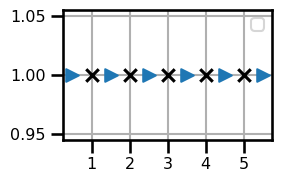

In [3]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(3, 2))

ax.scatter(q, np.ones_like(q), marker="x", color="black", zorder=2)
ax.scatter(u, np.ones_like(u), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.grid(which="both", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# check array is equal
u_on_q = F_grid.x_average_1D(u, padding="valid")

np.testing.assert_array_equal(u_on_q, q)

u, q, u_on_q

(Array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], dtype=float64),
 Array([1, 2, 3, 4, 5], dtype=int64),
 Array([1., 2., 3., 4., 5.], dtype=float64))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


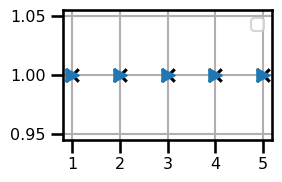

In [5]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(3, 2))

ax.scatter(q, np.ones_like(q), marker="x", color="black", zorder=2)
ax.scatter(u_on_q, np.ones_like(u_on_q), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.grid(which="both", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

### Interior Points

```python
# QOI
q: Array["Nx"] = ...
# U-Velocity
u: Array["Nx-1"] = ...
```

In [6]:
q = jnp.arange(1, 6)


# check size of new array
u = jnp.arange(1.5, 5.5)
assert len(q) == len(u) + 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


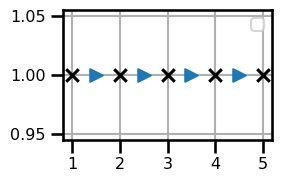

In [7]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(3, 2))

ax.scatter(q, np.ones_like(q), marker="x", color="black", zorder=2)
ax.scatter(u, np.ones_like(u), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.grid(which="both", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# check array is equal
u_on_q = F_grid.x_average_1D(u, padding="valid")
np.testing.assert_array_equal(u_on_q, q[1:-1])

u, q, u_on_q

(Array([1.5, 2.5, 3.5, 4.5], dtype=float64),
 Array([1, 2, 3, 4, 5], dtype=int64),
 Array([2., 3., 4.], dtype=float64))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


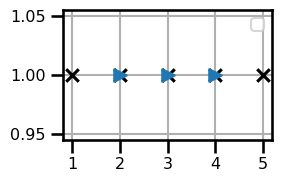

In [9]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(3, 2))

ax.scatter(q, np.ones_like(q), marker="x", color="black", zorder=2)
ax.scatter(u_on_q, np.ones_like(u_on_q), marker=">", color="tab:blue", zorder=2)
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.grid(which="both", zorder=1)
plt.legend()
plt.tight_layout()
plt.show()

## 2-Dimensional Field

In [10]:
from jaxsw._src.domain.base import Domain

In [11]:
n_rows = 3
n_cols = 5

# cell faces
q_domain = Domain(xmin=(1, 1), xmax=(n_rows + 1, n_cols + 1), dx=(1, 1))

# U Velocity
u_domain = Domain(xmin=(0.5, 1), xmax=(n_rows + 1.5, n_cols + 1), dx=(1, 1))

# V Velocity
v_domain = Domain(xmin=(1, 0.5), xmax=(n_rows + 1, n_cols + 1.5), dx=(1, 1))
v_domain.size

(3, 6)

In [12]:
v_domain.grid.shape

(3, 6, 2)

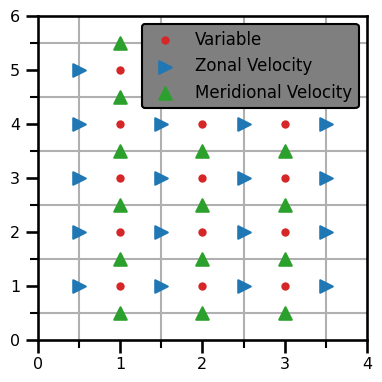

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(
    q_domain.grid[..., 0].ravel(),
    q_domain.grid[..., 1].ravel(),
    marker=".",
    color="tab:red",
    zorder=2,
    label="Variable",
)
ax.scatter(
    u_domain.grid[..., 0].ravel(),
    u_domain.grid[..., 1].ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_domain.grid[..., 0].ravel(),
    v_domain.grid[..., 1].ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[0, n_rows + 1], ylim=[0, n_cols + 1])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=12, edgecolor="black", framealpha=1.0, facecolor="tab:gray")
plt.tight_layout()
plt.show()

#### Velocities on Variable

In [14]:
# U-Velocity
u_on_q_x = F_grid.x_average_2D(u_domain.grid[..., 0])
u_on_q_y = F_grid.x_average_2D(u_domain.grid[..., 1])

np.testing.assert_array_equal(q_domain.grid[..., 0], u_on_q_x)
np.testing.assert_array_equal(q_domain.grid[..., 1], u_on_q_y)

# # v-Velocity
v_on_q_x = F_grid.y_average_2D(v_domain.grid[..., 0])
v_on_q_y = F_grid.y_average_2D(v_domain.grid[..., 1])

np.testing.assert_array_equal(q_domain.grid[..., 0], v_on_q_x)
np.testing.assert_array_equal(q_domain.grid[..., 1], v_on_q_y)

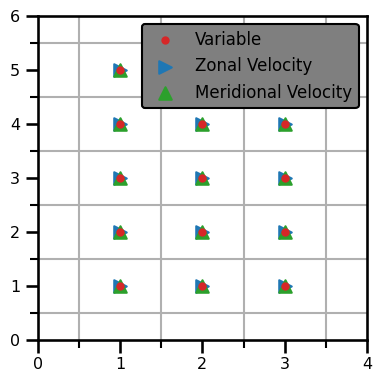

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(
    q_domain.grid[..., 0].ravel(),
    q_domain.grid[..., 1].ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Variable",
)
ax.scatter(
    u_on_q_x.ravel(),
    u_on_q_y.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_on_q_x.ravel(),
    v_on_q_y.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[0, n_rows + 1], ylim=[0, n_cols + 1])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=12, edgecolor="black", framealpha=1.0, facecolor="tab:gray")
plt.tight_layout()
plt.show()

### On U-Velocities

In [16]:
# Variable to U velocity
q_on_u_x = F_grid.x_average_2D(q_domain.grid[..., 0], padding="valid")
q_on_u_y = F_grid.x_average_2D(q_domain.grid[..., 1], padding="valid")

np.testing.assert_array_equal(u_domain.grid[1:-1, :, 0], q_on_u_x)
np.testing.assert_array_equal(u_domain.grid[1:-1, :, 1], q_on_u_y)

# # v-Velocity
v_on_u_x = F_grid.center_average_2D(v_domain.grid[..., 0], padding="valid")
v_on_u_y = F_grid.center_average_2D(v_domain.grid[..., 1], padding="valid")

np.testing.assert_array_equal(u_domain.grid[1:-1, :, 0], v_on_u_x)
np.testing.assert_array_equal(u_domain.grid[1:-1, :, 1], v_on_u_y)

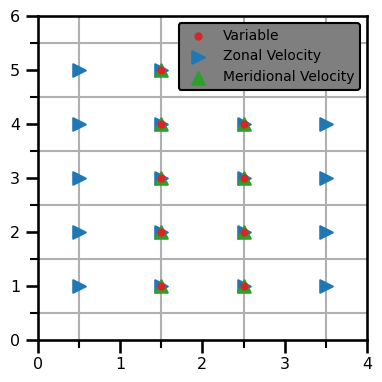

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(
    q_on_u_x.ravel(),
    q_on_u_y.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Variable",
)
ax.scatter(
    u_domain.grid[..., 0].ravel(),
    u_domain.grid[..., 1].ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_on_u_x.ravel(),
    v_on_u_y.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[0, n_rows + 1], ylim=[0, n_cols + 1])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="tab:gray")
plt.tight_layout()
plt.show()

### On V-Velocities

In [18]:
# Variable to U velocity
q_on_v_x = F_grid.y_average_2D(q_domain.grid[..., 0], padding="valid")
q_on_v_y = F_grid.y_average_2D(q_domain.grid[..., 1], padding="valid")

np.testing.assert_array_equal(v_domain.grid[:, 1:-1, 0], q_on_v_x)
np.testing.assert_array_equal(v_domain.grid[:, 1:-1, 1], q_on_v_y)

# # v-Velocity
u_on_v_x = F_grid.center_average_2D(u_domain.grid[..., 0], padding="valid")
u_on_v_y = F_grid.center_average_2D(u_domain.grid[..., 1], padding="valid")

np.testing.assert_array_equal(v_domain.grid[:, 1:-1, 0], u_on_v_x)
np.testing.assert_array_equal(v_domain.grid[:, 1:-1, 1], u_on_v_y)

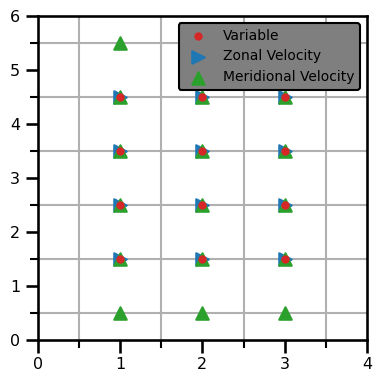

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(
    q_on_v_x.ravel(),
    q_on_v_y.ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Variable",
)
ax.scatter(
    u_on_v_x.ravel(),
    u_on_v_y.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_domain.grid[..., 0].ravel(),
    v_domain.grid[..., 1].ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[0, n_rows + 1], ylim=[0, n_cols + 1])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="tab:gray")
plt.tight_layout()
plt.show()

## Advanced 2-Dimensional Example

In this example, we'll look at two variables along with their corresponding velocities.
The inspiration comes from the QG equation where we have

$$
\begin{aligned}
\partial_t q + \vec{u}\cdot q &= 0 \\
q = \boldsymbol{\nabla}_H \psi
\end{aligned}
$$

where we have four variables we need to handle in total:

* $q$ - potential vorticity on the cell faces
* $u$ - zonal velocity on the East-West cell edges
* $v$ - meridional velocity on the North-South cell edges
* $\psi$ - stream function on the cell corners.

In [20]:
n_rows = 3
n_cols = 5

# cell corners
psi_domain = Domain(xmin=(0, 0), xmax=(n_rows + 1, n_cols + 1), dx=(1, 1))

# cell faces
q_domain = Domain(xmin=(0.5, 0.5), xmax=(n_rows + 0.5, n_cols + 0.5), dx=(1, 1))

# U Velocity
u_domain = Domain(xmin=(0.5, 0), xmax=(n_rows + 0.5, n_cols + 1), dx=(1, 1))

# V Velocity
v_domain = Domain(xmin=(0, 0.5), xmax=(n_rows + 1, n_cols + 0.5), dx=(1, 1))

psi_domain.size, q_domain.size, u_domain.size, v_domain.size

((4, 6), (3, 5), (3, 6), (4, 5))

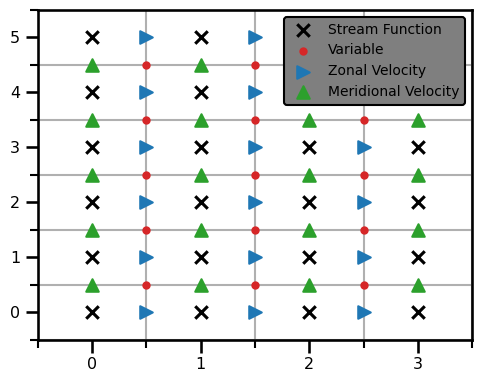

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_domain.grid[..., 0].ravel(),
    psi_domain.grid[..., 1].ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    q_domain.grid[..., 0].ravel(),
    q_domain.grid[..., 1].ravel(),
    marker=".",
    color="tab:red",
    zorder=2,
    label="Variable",
)
ax.scatter(
    u_domain.grid[..., 0].ravel(),
    u_domain.grid[..., 1].ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_domain.grid[..., 0].ravel(),
    v_domain.grid[..., 1].ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-0.5, n_rows + 0.5], ylim=[-0.5, n_cols + 0.5])
ax.grid(
    which="minor",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="tab:gray")
plt.tight_layout()
plt.show()

### Stream Function to Velocities

In [22]:
# compute stream to u grid (cell corners to cell East-West Edges)
psi_on_u_x = F_grid.x_average_2D(psi_domain.grid[..., 0])
psi_on_u_y = F_grid.x_average_2D(psi_domain.grid[..., 1])
assert psi_on_u_x.shape == psi_on_u_y.shape == u_domain.grid[..., 0].shape

# compute stream to v grid (cell corners to cell North-South Edges)
psi_on_v_x = F_grid.y_average_2D(psi_domain.grid[..., 0])
psi_on_v_y = F_grid.y_average_2D(psi_domain.grid[..., 1])
assert psi_on_v_x.shape == psi_on_v_y.shape == v_domain.grid[..., 0].shape

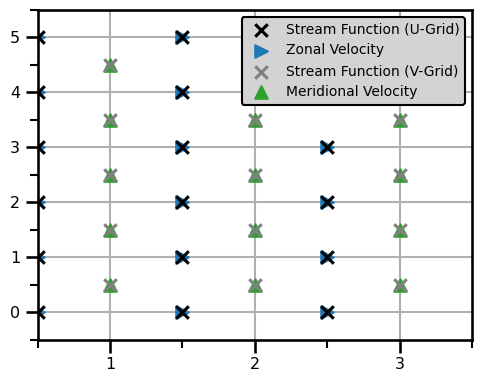

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    psi_on_u_x.ravel(),
    psi_on_u_y.ravel(),
    marker="x",
    color="black",
    zorder=3,
    label="Stream Function (U-Grid)",
)
ax.scatter(
    u_domain.grid[..., 0].ravel(),
    u_domain.grid[..., 1].ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)

ax.scatter(
    psi_on_v_x.ravel(),
    psi_on_v_y.ravel(),
    marker="x",
    color="gray",
    zorder=3,
    label="Stream Function (V-Grid)",
)
ax.scatter(
    v_domain.grid[..., 0].ravel(),
    v_domain.grid[..., 1].ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[0.5, n_rows + 0.5], ylim=[-0.5, n_cols + 0.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()

### Variables to Vorticity

In [24]:
# compute stream to q grid (cell corners to cell faces)
psi_on_q_x = F_grid.center_average_2D(psi_domain.grid[..., 0])
psi_on_q_y = F_grid.center_average_2D(psi_domain.grid[..., 1])
assert psi_on_q_x.shape == psi_on_q_y.shape == q_domain.grid[..., 0].shape

# compute stream to u grid (cell East-West EDGES to cell FACE)
u_on_q_x = F_grid.y_average_2D(u_domain.grid[..., 0])
u_on_q_y = F_grid.y_average_2D(u_domain.grid[..., 1])
assert u_on_q_x.shape == u_on_q_y.shape == q_domain.grid[..., 0].shape

# compute stream to v grid (cell North-South EDGES to cell FACE)
v_on_q_x = F_grid.x_average_2D(v_domain.grid[..., 0])
v_on_q_y = F_grid.x_average_2D(v_domain.grid[..., 1])
assert v_on_q_x.shape == v_on_q_y.shape == q_domain.grid[..., 0].shape

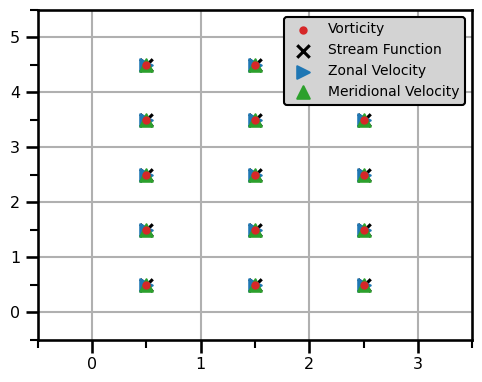

In [25]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(
    q_domain.grid[..., 0].ravel(),
    q_domain.grid[..., 1].ravel(),
    marker=".",
    color="tab:red",
    zorder=3,
    label="Vorticity",
)
ax.scatter(
    psi_on_q_x.ravel(),
    psi_on_q_y.ravel(),
    marker="x",
    color="black",
    zorder=2,
    label="Stream Function",
)
ax.scatter(
    u_on_q_x.ravel(),
    u_on_q_y.ravel(),
    marker=">",
    color="tab:blue",
    zorder=2,
    label="Zonal Velocity",
)
ax.scatter(
    v_on_q_x.ravel(),
    v_on_q_y.ravel(),
    marker="^",
    color="tab:green",
    zorder=2,
    label="Meridional Velocity",
)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.set(xlim=[-0.5, n_rows + 0.5], ylim=[-0.5, n_cols + 0.5])
ax.grid(
    which="major",
    zorder=1,
)
plt.legend(fontsize=10, edgecolor="black", framealpha=1.0, facecolor="lightgray")
plt.tight_layout()
plt.show()